# Tutorial on using DMI data

This Python notebook presents a convenient function for retrieving meteorological observation data from the Danish Meteorological Institute (DMI). DMI offers observational data from both Denmark and Greenland.

You can read more about DMI's free data API in this [blog post](https://predictablysunny.com/posts/dmi_data/).

<br>

## Step 0: Familiarize yourself with Google Colab

The notebook can be seamlessly run in Google Colab, a free no-installation tool for running Python code from your web browser. 

Notebooks are organized by text and code "cells".  You can double-click a cell to start editing it.  To render a text cell, or execute a code cell, hit shift+enter.

In the code cell below, try out some math calculations to explore how the notebook and Python works:

In [1]:
# Try and write some code here


## Step 1: Import packages

The first step in almost all Python scripts is to load some packages also known as libraries:

In [2]:
import pandas as pd  # package for data analysis
import numpy as np  # package for math operations
import matplotlib.pyplot as plt  # package for plotting
import requests  # package for making web requests

## Step 2: Specify your data requirements

Modify the parameters below to tailor your data request.

You can find a list of meterological parameters [**here**](https://opendatadocs.dmi.govcloud.dk/en/Data/Meteorological_Observation_Data) and a list of available stations [**here**](https://opendatadocs.dmi.govcloud.dk/Data/Meteorological_Observation_Data_Stations).

In [3]:
# Specify all the Greenlandic active stations
station = '04234'

start_time = '2020-01-01'
end_time = '2020-01-05'

api_key = '380d1f5b-3862-49e1-af1f-08ae0b51ed9a'

# Specify global radiation
parameterIds = ['temp_dry', 'wind_speed', 'wind_dir']

<br>
The below code you don't have to worry about. Though you do need to run the cell.

In [4]:
# API endpoint
DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'

# Derive datetime specifier string
datetime_str = (
    pd.Timestamp(start_time).tz_localize('UTC').isoformat()
    + '/'
    + pd.Timestamp(end_time).tz_localize('UTC').isoformat()
)

dfs = []
for parameter in parameterIds:
    params = {
        'api-key': api_key,
        'datetime': datetime_str,
        'stationId': station,
        'parameterId': parameter,
        'limit': '300000',
    }

    ii = 0
    dfis = []
    while True:
        if ii == 0:
            ii += 1
            r = requests.get(DMI_URL, params=params)
        else:
            ii += 1
            link = r.json().get('links', [])
            if link and link[-1]['title'] == 'Next set of results':
                url = link[-1]['href']
                r = requests.get(url)
            else:
                break

        json = r.json()
        dfi = pd.json_normalize(json.get('features', []))
        if dfi.empty:
            continue
        dfi['time'] = pd.to_datetime(dfi['properties.observed'])
        dfi = dfi[['time', 'properties.value', 'properties.stationId', 'properties.parameterId']]
        dfi.columns = [c.replace('properties.', '') for c in dfi.columns]
        dfi = dfi[~dfi.duplicated()]
        dfi = dfi.set_index(['parameterId', 'time'])
        dfi = dfi['value'].unstack(['parameterId'])
        dfis.append(dfi)

    if not dfis:
        print(f"Station has no data: {station} for parameter: {parameter}")
        continue

    dfs.append(pd.concat(dfis, axis='rows').sort_index())

if not dfs:
    print(f"No data collected for station {station}. Skipping...")

df = pd.concat(dfs, axis='columns')

## Step 3: Inspect the retrieved data

The retrieved data is in a Pandas DataFrame (``df``):

In [7]:
df.head()  # print the first five rows

parameterId,temp_dry,wind_speed,wind_dir
time,,,
2020-01-01 00:00:00+00:00,-12.5,2.4,92.0
2020-01-01 01:00:00+00:00,-12.5,3.3,94.0
2020-01-01 02:00:00+00:00,-12.3,3.3,94.0
2020-01-01 03:00:00+00:00,-11.7,2.3,91.0
2020-01-01 04:00:00+00:00,-11.9,4.1,89.0


<br>
Plot the retrieved data:

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

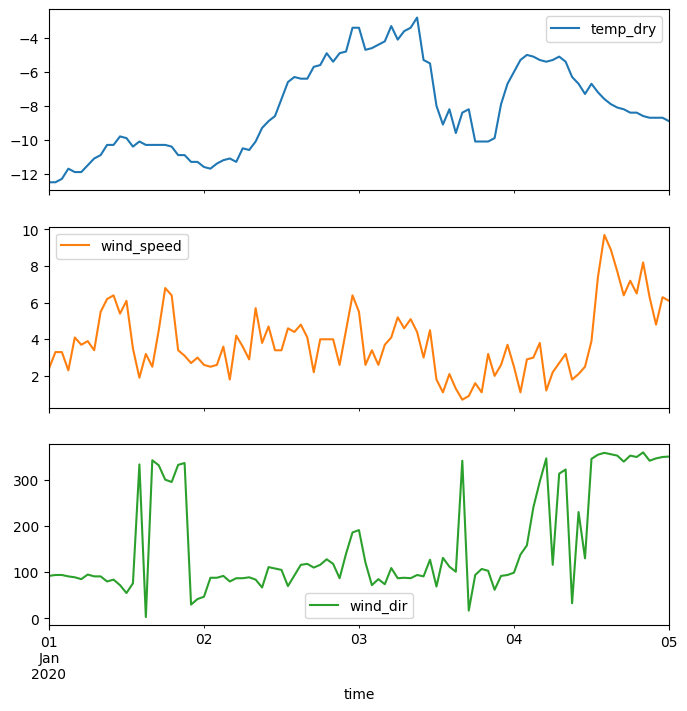

In [5]:
df.plot(figsize=(8, 8), sharex=True, subplots=True)